# Explain a saved pytorch NLP model

*This is a torturial on how to explain any saved pytorch model. We use pre-trained BERT model for simplicity as an example*

### Prepare Phi, x, words and regularization term

we first load the pre-trained model we need to explain and define the sentence we use in our case. The sentence we use is `rare bird has more than enough charm to make it memorable.`, and the layer we explain in BERT is the 3rd layer.

In [1]:
from pytorch_pretrained_bert import BertModel, BertTokenizer
import torch
import json
import logging
import sys

logging.getLogger().setLevel(logging.WARNING)

sys.path.append("../../")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# the sentence in our case.
text = "rare bird has more than enough charm to make it memorable."

# get the tokenized words.
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
words = ["[CLS]"] + tokenizer.tokenize(text) + ["[SEP]"]

# load bert model
model = BertModel.from_pretrained("bert-base-uncased").to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

# get the x (here we get x by hacking the code in the bert package)
tokenized_ids = tokenizer.convert_tokens_to_ids(words)
segment_ids = [0 for _ in range(len(words))]
token_tensor = torch.tensor([tokenized_ids], device=device)
segment_tensor = torch.tensor([segment_ids], device=device)
x = model.embeddings(token_tensor, segment_tensor)[0]

# here, we load the regularization we already calculated for simplicity
regularization = json.load(open("regular.json", "r"))

# extract the Phi we need to explain
def Phi(x):
    global model
    x = x.unsqueeze(0)
    attention_mask = torch.ones(x.shape[:2]).to(x.device)
    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
    extended_attention_mask = extended_attention_mask.to(dtype=torch.float)
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
    # extract the 3rd layer
    model_list = model.encoder.layer[:3]
    hidden_states = x
    for layer_module in model_list:
        hidden_states = layer_module(hidden_states, extended_attention_mask)
    return hidden_states[0]

### Explain the Phi and x

We first initialize an interpreter class, and pass necessary parameters in it.

In [2]:
from utils_nlp.interpreter.Interpreter import Interpreter

interpreter = Interpreter(x=x, Phi=Phi, regularization=regularization, words=words).to(
    device
)

We optimize the interpreter to get the result.

In [3]:
interpreter.optimize(iteration=5000, lr=0.01, show_progress=False)

Then, we can get the sigma we have optimized

In [4]:
interpreter.get_sigma()

array([0.17756101, 0.14380291, 0.15160355, 0.23105706, 0.21252151,
       0.20955776, 0.18730533, 0.1380216 , 0.26319018, 0.23216105,
       0.24160075, 0.13294625, 0.27567503, 0.3655964 ], dtype=float32)

Finally, we visualize the explained result.

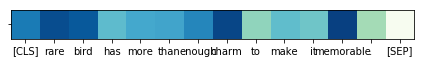

In [5]:
interpreter.visualize()

We can see that the word 'rare', 'bird', 'charm', 'memorable' is important to the third layer.